In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import re
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import spearmanr
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing as pp
from scipy.signal import argrelextrema
from sklearn.metrics import r2_score

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### 1. Load all files

In [3]:
# Group Bigrams by Date and Stemmed_Bigram
df = pd.read_csv('/Users/mac/Desktop/Bigrams_popcorn.csv')
df['Date'] = pd.to_datetime(df.Date)
df['Frequency'] = df["Percentage"]

df_pop = df.groupby(['Date','Stemmed_Bigram'])['Frequency'].agg("sum").reset_index()
df_pop.sort_values(['Date','Frequency'],ascending=(True,False)).reset_index(drop = True) 

,Date,Stemmed_Bigram,Frequency
0,2020-10-25,popcorn popper,0.145044
1,2020-10-25,maker popcorn,0.093902
2,2020-10-25,air popcorn,0.093846
3,2020-10-25,machin popcorn,0.092757
4,2020-10-25,air popper,0.085414
...,...,...,...
20911,2022-05-22,star war,0.000000
20912,2022-05-22,steel whirley,0.000000
20913,2022-05-22,stick stir,0.000000
20914,2022-05-22,stir west,0.000000


In [4]:
#Load the Popcorn Bigrams Chosen by Epoca Team
df_bigrams = pd.read_csv('/Users/mac/Desktop/Bigrams_Popcorn_Epoca.csv')
# df_bigrams
bigrams = df_bigrams['Stemmed_Bigram'].tolist()
bigrams

['popcorn popper',
 'maker popcorn',
 'air popcorn',
 'air popper',
 'machin popcorn',
 'microwav popcorn',
 'air hot',
 'hot popcorn',
 'dash popcorn',
 'popcorn silicon',
 'popper silicon',
 'nostalgia popcorn',
 'movi style',
 'contain popcorn',
 'campfir popcorn',
 'collaps popcorn',
 'ecolut microwav',
 'ecolut popcorn',
 'ecolut popper',
 'ecolut origin',
 'ecolut micropop',
 'micropop origin',
 'micropop microwav',
 'micropop popcorn',
 'contain reusabl',
 'microwav silicon',
 'glass popcorn',
 'glass microwav',
 'micropop popcorn',
 'maker whir',
 'collaps silicon',
 'famili popcorn',
 'popco silicon',
 'fresh pop',
 'fresh popcorn']

### 2. Functions to Detect Patterns¶

In [5]:
# Pattern 1: Strictly Above the Threshold
def pattern1(epoca_list, threshold):
    if min(epoca_list) >= threshold:
        return "√"
    else:
        return " "

In [6]:
# Pattern 2: Notable Trend 
def pattern2(lst):
    count_o = count_p = count_m = count_O = count_P = count_M =0
    for i in range(0,int(len(lst)/3*2)):  
        if lst[i] == "o": 
            count_o = count_o+1
        elif lst[i] == "+":
            count_p = count_p+1
        else:
            count_m = count_m+1
    
    for i in range(len(lst)-1, int(len(lst)/3*1),-1):
        if lst[i] == "o": 
            count_O = count_O+1
        elif lst[i] == "+":
            count_P = count_P+1
        else:
            count_M = count_M+1
     
#     print(count_o, count_p, count_m, count_O, count_P, count_M)

    if count_o >= int(len(lst)*0.3) and count_P > int(len(lst)/8) and count_M <= int(len(lst)/8):
        return "√"
    else: 
        return ""

In [7]:
# Pattern 3: Declining Trend
def pattern3(slope,intercept,pvalue,rsquare):
    if slope<0  and intercept > 0 and pvalue <  0.05 and rsquare>0.2:
        return '√'
    else: return ""

In [8]:
# Pattern 4: Peak Trend
def pattern4(a,b):
    Frequency = np.array(a)

    #peak
    peak = argrelextrema(Frequency, np.greater)        
    c = len(peak[0][Frequency[peak[0]] >= max(b)*1.12])

    #valley
    valley = argrelextrema(Frequency, np.less)        
    d = len(valley[0][Frequency[valley[0]] < max(b)])
    
    if 0 <c <int(len(a)*0.09) and d >= int(len(a)*0.1):
        return '√'
    else: return ""

### 3. Year 2020-2022

In [24]:
#Filter out all the Epoca chosen bigrams.
df_1 = [df_pop[df_pop['Stemmed_Bigram'] == bigrams[i]] for i in range(len(bigrams))]
df_1

[            Date  Stemmed_Bigram  Frequency
 200   2020-10-25  popcorn popper   0.145044
 452   2020-11-01  popcorn popper   0.138216
 704   2020-11-08  popcorn popper   0.155912
 956   2020-11-15  popcorn popper   0.158539
 1208  2020-11-22  popcorn popper   0.175510
 ...          ...             ...        ...
 19856 2022-04-24  popcorn popper   0.144915
 20108 2022-05-01  popcorn popper   0.094414
 20360 2022-05-08  popcorn popper   0.126879
 20612 2022-05-15  popcorn popper   0.116204
 20864 2022-05-22  popcorn popper   0.146639
 
 [83 rows x 3 columns],
             Date Stemmed_Bigram  Frequency
 138   2020-10-25  maker popcorn   0.093902
 390   2020-11-01  maker popcorn   0.085780
 642   2020-11-08  maker popcorn   0.099000
 894   2020-11-15  maker popcorn   0.091648
 1146  2020-11-22  maker popcorn   0.092763
 ...          ...            ...        ...
 19794 2022-04-24  maker popcorn   0.082377
 20046 2022-05-01  maker popcorn   0.049471
 20298 2022-05-08  maker popcorn   0.0

### 3.1 Plot Trendlines

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_50802/2007642234.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,5))


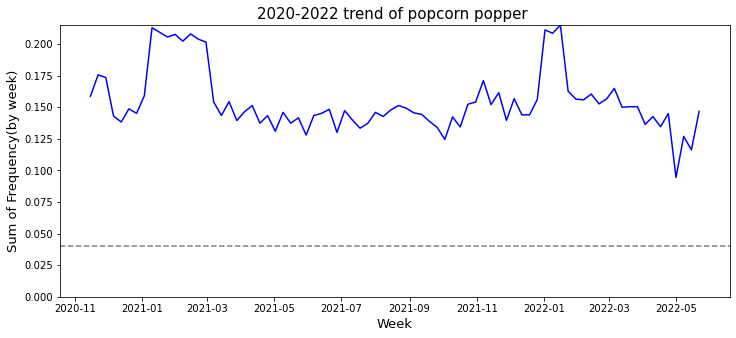

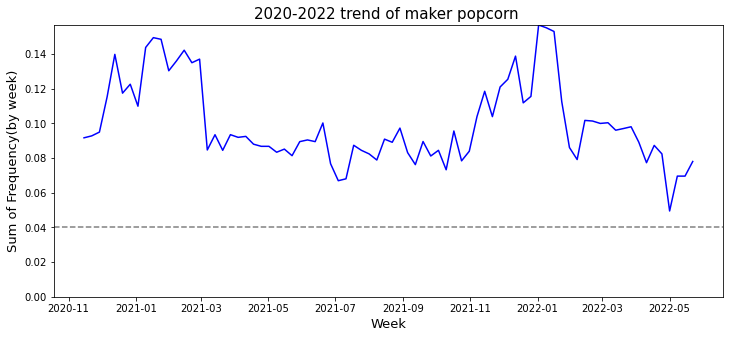

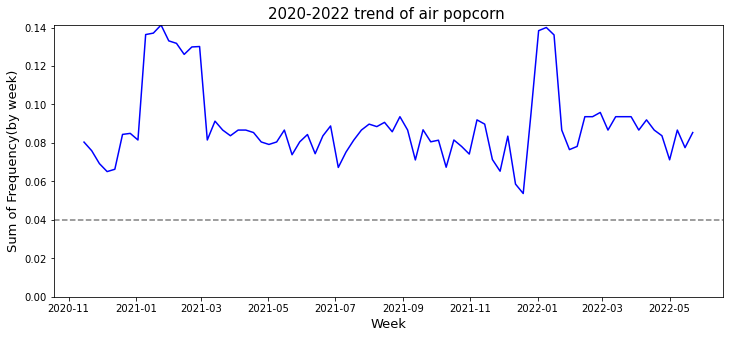

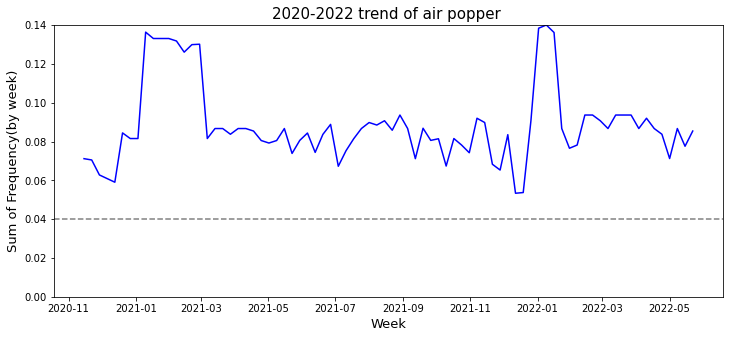

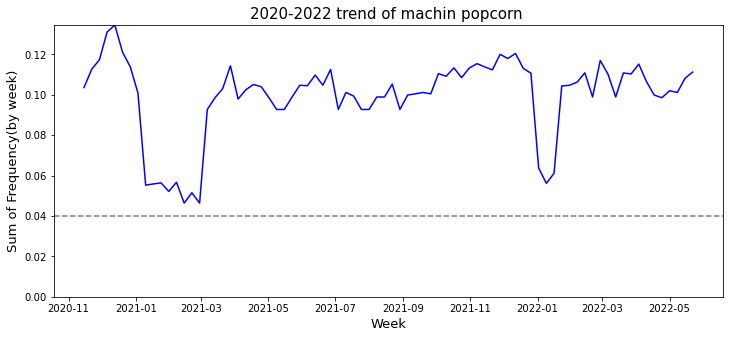

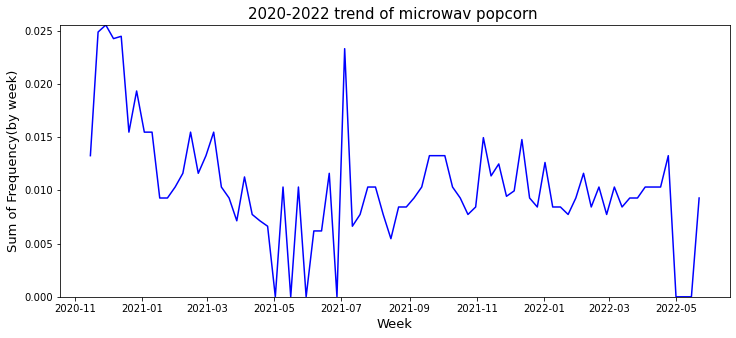

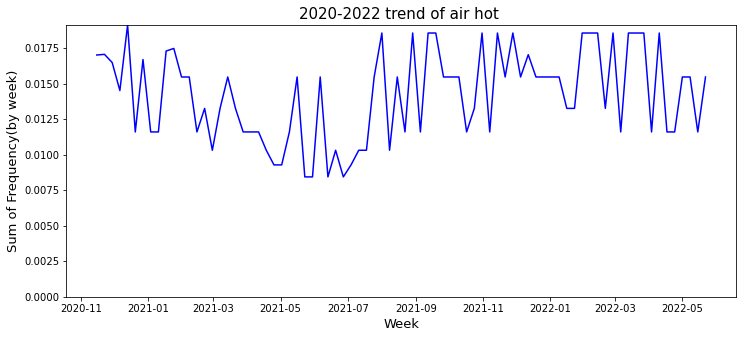

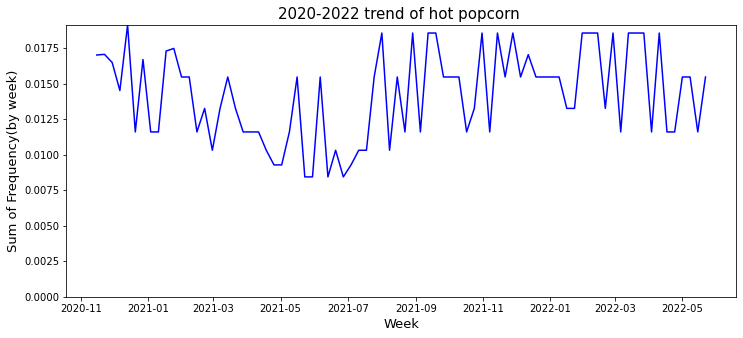

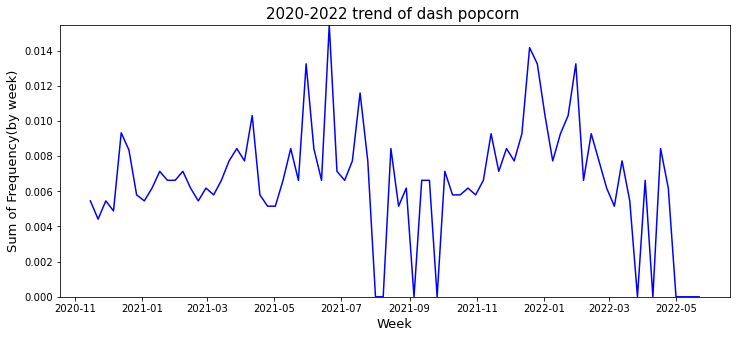

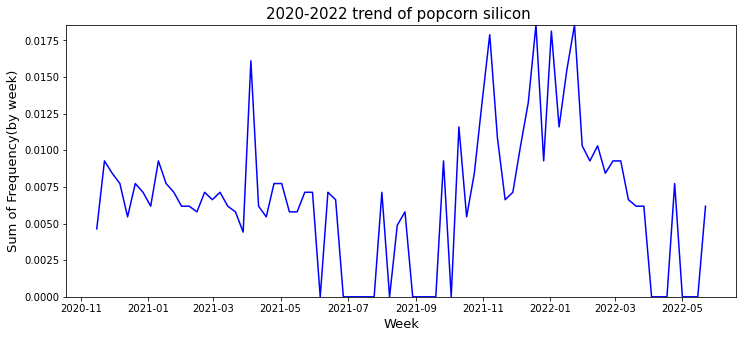

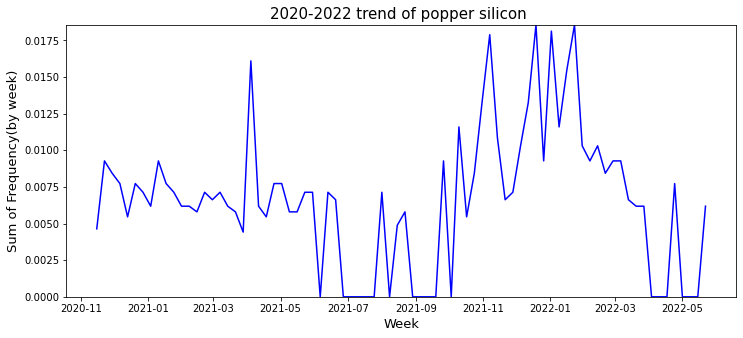

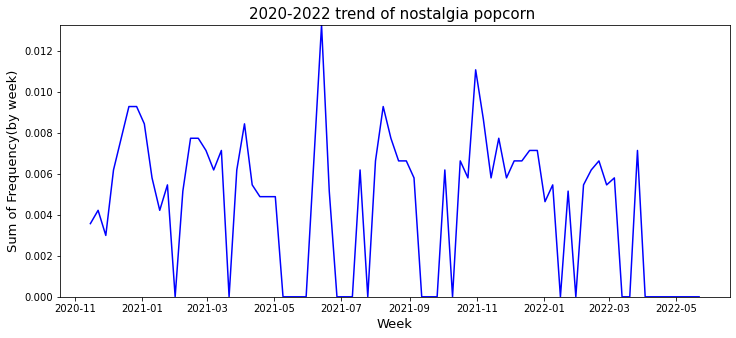

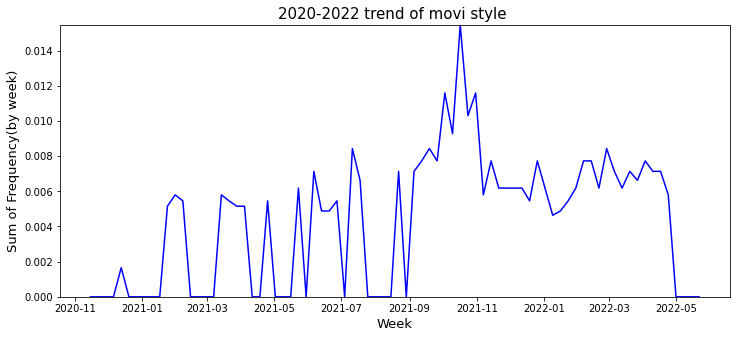

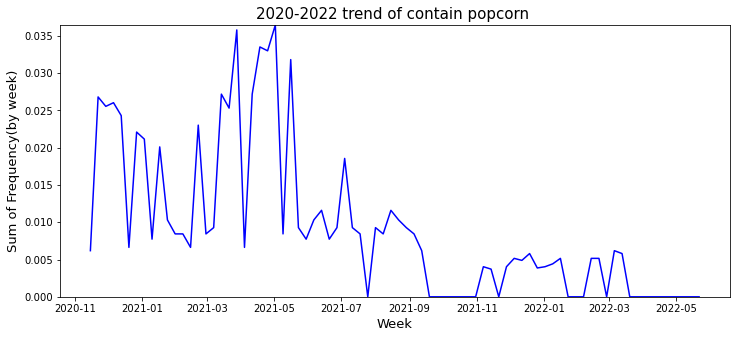

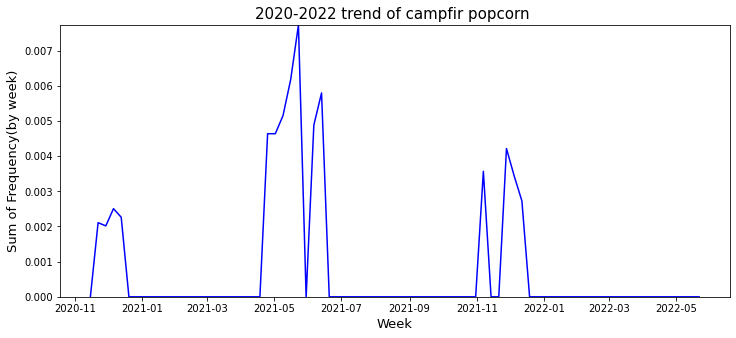

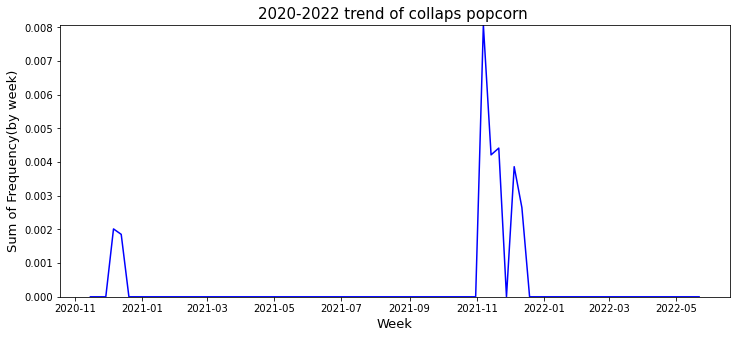

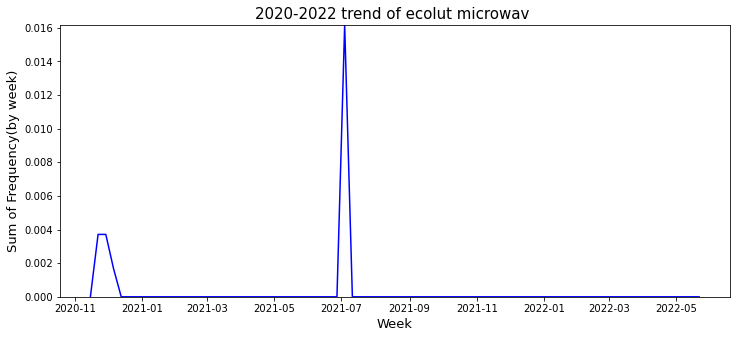

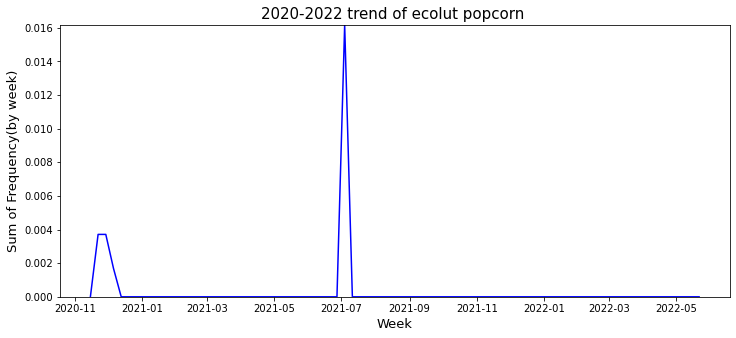

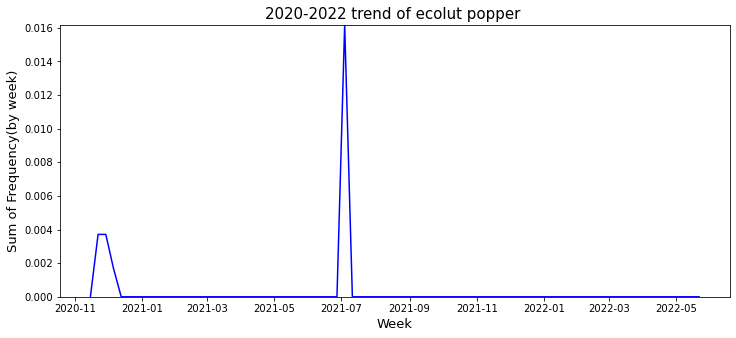

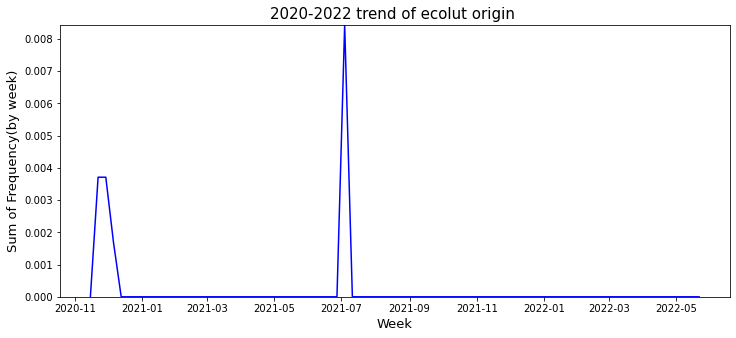

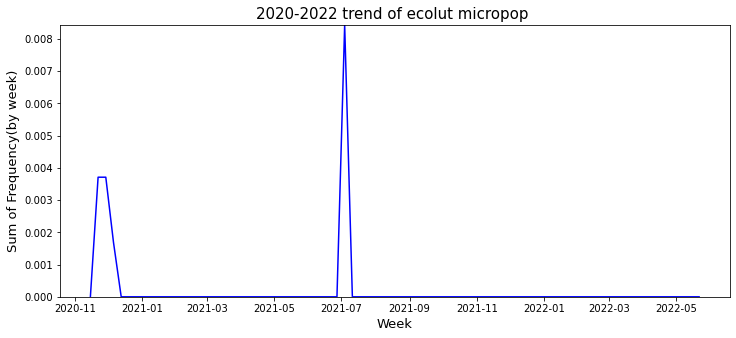

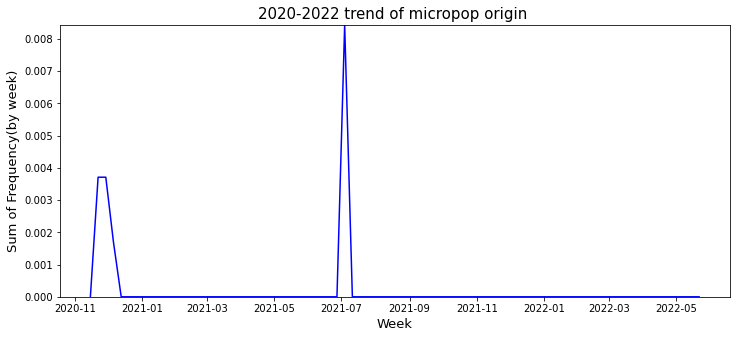

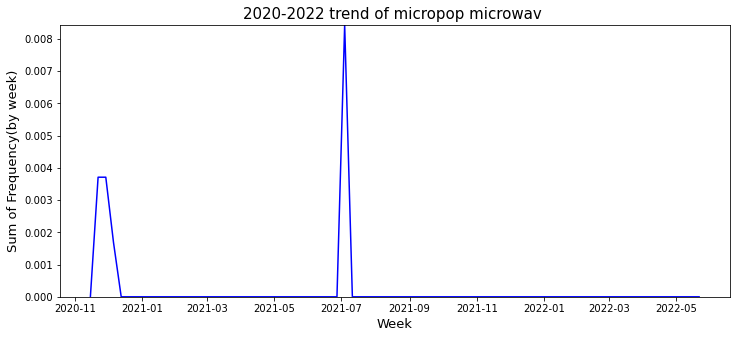

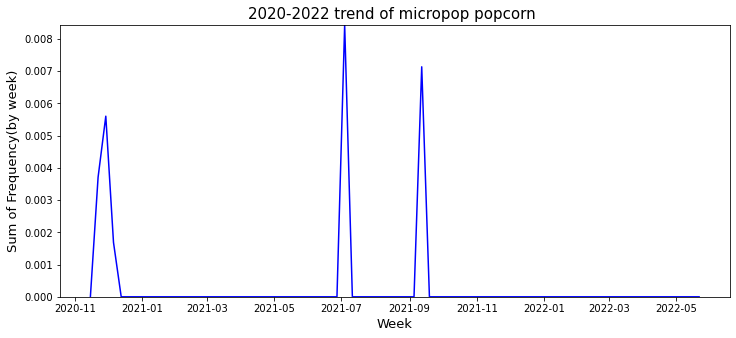

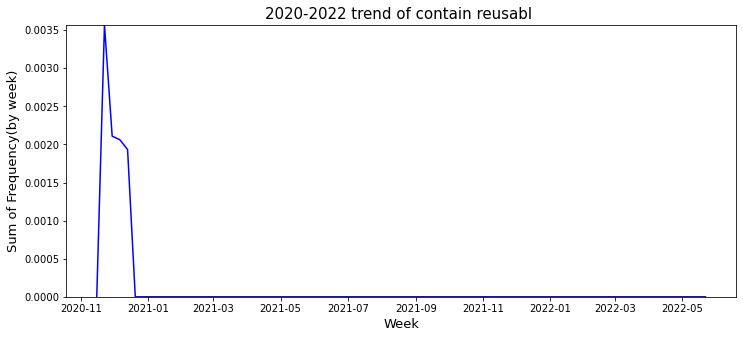

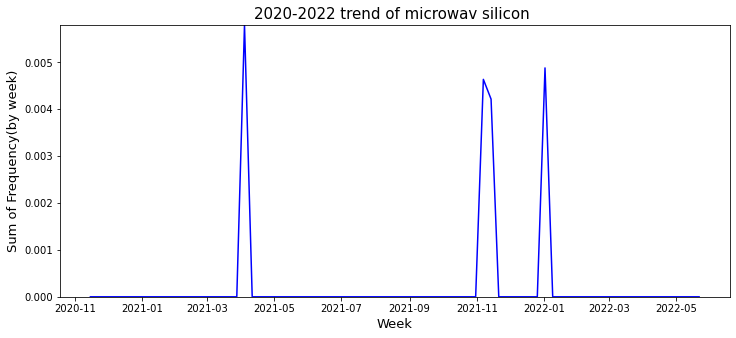

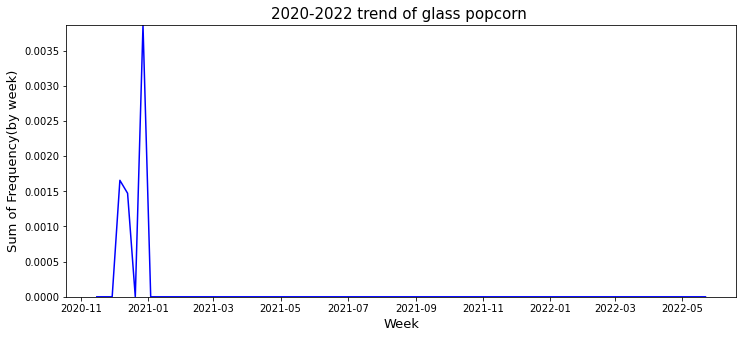

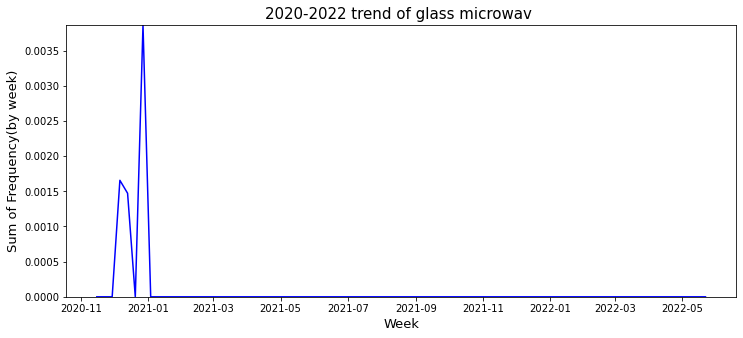

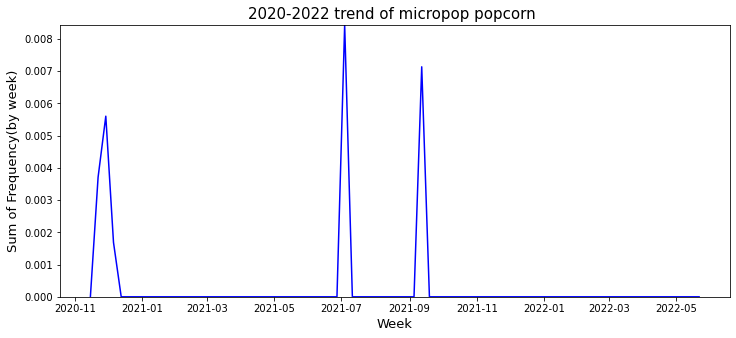

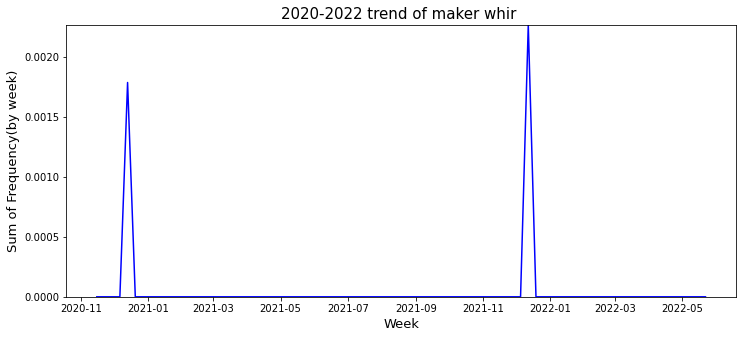

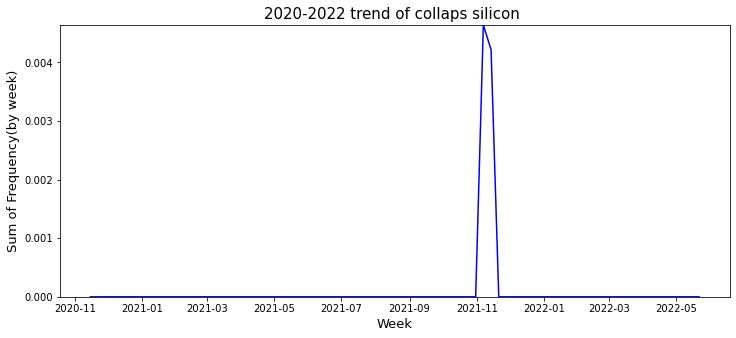

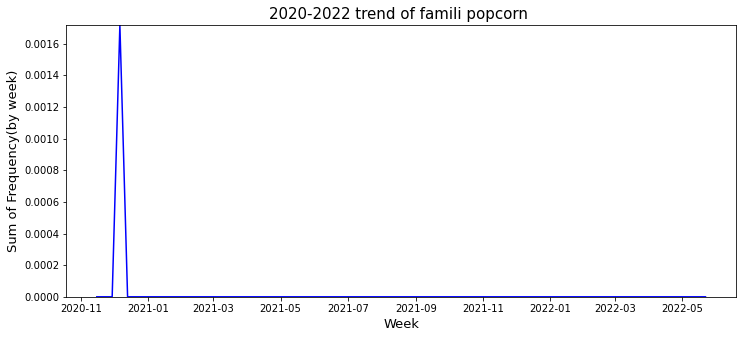

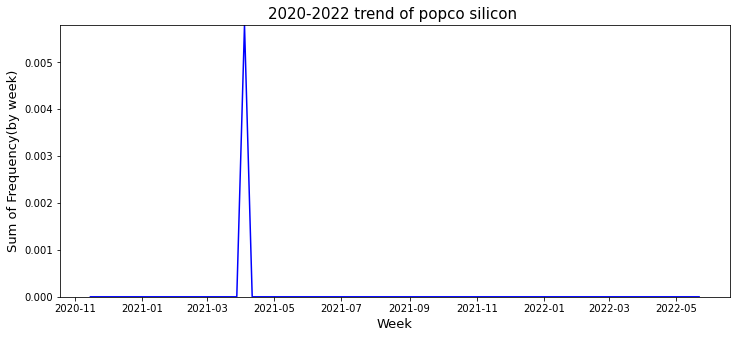

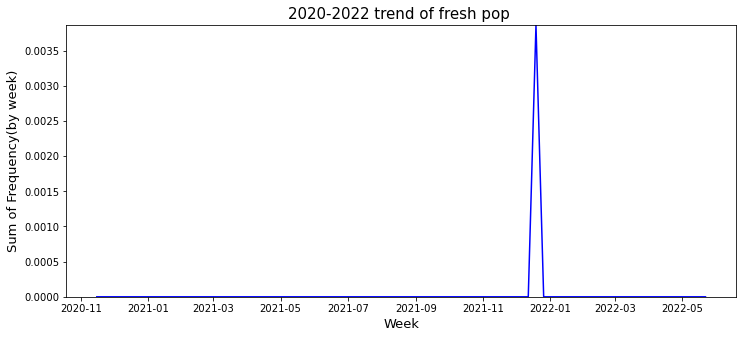

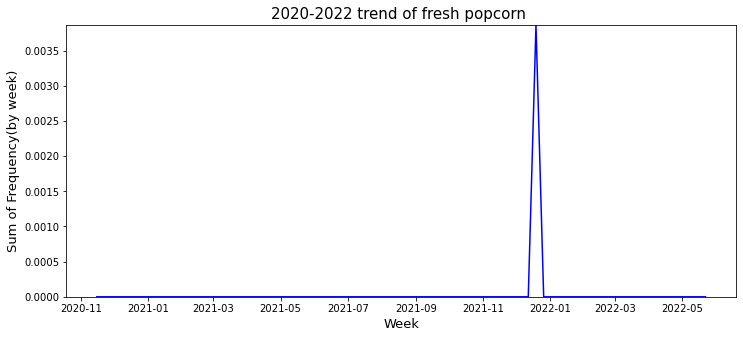

In [91]:
# Plot all Bigrams from 2020-2022 individually
for i in range(len(df_1)):
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot( df_1[i]['Date'], df_1[i]['Frequency'],'b')
    ax.set_title("2020-2022 trend of %s "%max(df_1[i]["Stemmed_Bigram"]), fontsize=15)
    ax.set_ylabel('Sum of Frequency(by week)', fontsize=13)
    ax.set_xlabel('Week', fontsize=13)
    ax.axhline(y = 0.04, color = 'grey', linestyle = '--', label='thresholds')
    ax.set_ylim([0,max(df_1[i]["Frequency"])])   

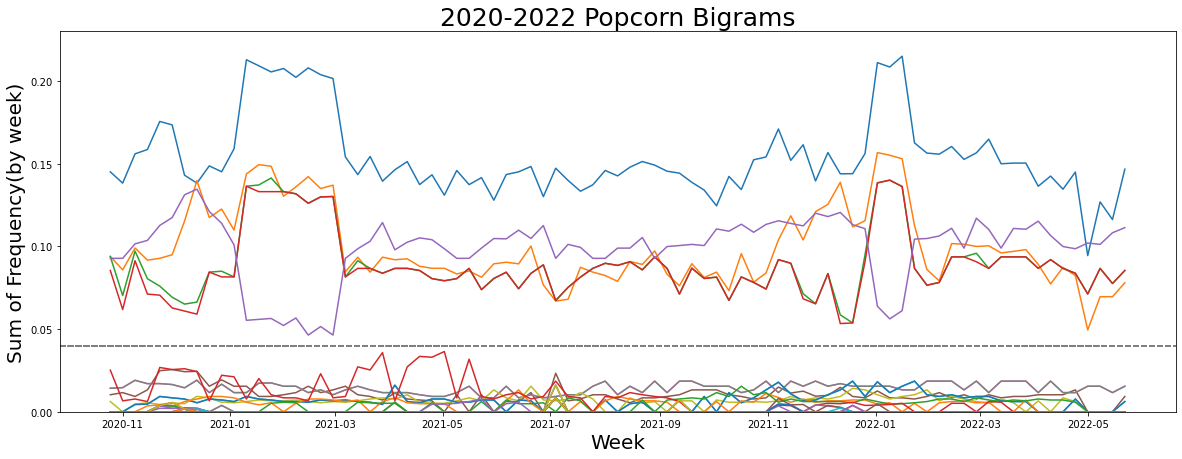

In [12]:
# Plot all Bigrams from 2020-2022 on the same scale
for i in range(len(df_1)):
#     fig, ax = plt.subplots()
    plt.figure(num = 10,figsize=(20,7))
    plt.plot( df_1[i]['Date'], df_1[i]['Frequency'],label = r"%s "%max(df_1[i]["Stemmed_Bigram"]))
    
    plt.title("2020-2022 Popcorn Bigrams", fontsize=25)
    plt.xlabel('Week', fontsize=20)
    plt.ylabel('Sum of Frequency(by week)', fontsize=20)
    plt.axhline(y = 0.04, color = 'grey', linestyle = '--', label='thresholds')
    plt.ylim([0,0.23])

### 3.2 Detect Patterns
### 3.2.1 Pattern1: Set threshold: Sum of frequency > = 0.04

In [38]:
df_1_pattern1 = [pattern1(df_1[i]["Frequency"].tolist(),0.04) for i in range(len(df_1))]
df_1_pattern1

['√',
 '√',
 '√',
 '√',
 '√',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

### 3.2.2 Pattern2: Notable Trend

In [30]:
# Calculate the Frequency_diff Dataframe
for i in range(len(df_1)):
    df_1[i]["Freq_Mean"] = df_1[i]["Frequency"].mean()
    df_1[i]["Freq_Lag"] = df_1[i]['Frequency'].shift(1)
    df_1[i]["Freq_Diff"] = pd.DataFrame(df_1[i]["Frequency"]-df_1[i]["Freq_Lag"])
    df_1[i]["Freq_Diff_Std"] = pp.scale(df_1[i]["Freq_Diff"]) #standardize
    df_1[i] = df_1[i].iloc[1:]  #delete first row(no difference value)
    
# divide all bigrams into 3 categories:
def mark(a): 
    if a > 1:
        return '+'
    elif a <= -1:
        return '-'
    else:
        return 'o'
    
df_mark = [(df_1[i].apply(lambda x: mark(x['Freq_Diff_Std']),axis=1))for i in range(len(df_1))]

for i in range(len(df_1)):
    df_1[i]["Label"] = df_mark[i]

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_50802/4029807224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i]["Freq_Mean"] = df_1[i]["Frequency"].mean()
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_50802/4029807224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[i]["Freq_Lag"] = df_1[i]['Frequency'].shift(1)
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_50802/4029807224.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [32]:
df_1_pattern2 = [pattern2(df_1[i]['Label'].tolist()) for i in range(len(df_1))]
df_1_pattern2

['',
 '',
 '',
 '',
 '',
 '',
 '√',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 3.2.3 Pattern3: Declining Trend

In [34]:
# Calculate Coefficient, R squared, and Correlation
lst1 = []
for i in range(len(df_1)):
    
    lst = []
    x = np.array([i for i in range(len(df_1[i]))]).reshape(-1,1)
    y = df_1[i]["Frequency"].values.reshape(-1,1)
    y.flatten()
    
    lst.append(max(df_1[i]["Stemmed_Bigram"]))
    model = LinearRegression()
    model.fit(x,y)
    
    Coefficient = model.coef_
    Coefficient = round(float(Coefficient),6)
    lst.append(Coefficient)
    
#     Coefficient_std = Coefficient/ df_[i]["Frequency"].mean()
#     lst.append(Coefficient_std)
    
    Intercept = model.intercept_
    Intercept = round(float(Intercept),4)
    lst.append(Intercept)
    
    R_Square = model.score(x,y)
    R_Square = round(float(R_Square),4)
    lst.append(R_Square)
    
    corr,p = spearmanr(x,y)
    lst.append(corr)
    lst.append(p)
    
    lst1.append(lst)

df_1_1 = pd.DataFrame(lst1, columns = ["Bigram","Coefficient",'Intercept',"R_Square","Correlation","P_Value"]).round(6)
df_1_1

,Bigram,Coefficient,Intercept,R_Square,Correlation,P_Value
0,popcorn popper,-0.000303,0.1662,0.0822,-0.173501,0.123777
1,maker popcorn,-0.000274,0.1105,0.0715,-0.255943,0.021934
2,air popcorn,-0.000121,0.0940,0.0195,0.055373,0.625657
3,air popper,-0.000087,0.0918,0.0098,0.093756,0.408119
4,machin popcorn,0.000206,0.0912,0.0585,0.202343,0.071861
5,microwav popcorn,-0.000093,0.0140,0.1644,-0.333203,0.002526
6,air hot,0.000030,0.0130,0.0485,0.215883,0.054446
7,hot popcorn,0.000030,0.0130,0.0485,0.215883,0.054446
8,dash popcorn,-0.000017,0.0073,0.0150,0.008993,0.936896
9,popcorn silicon,0.000008,0.0063,0.0015,0.063688,0.574630


In [35]:
df_1_pattern3 = df_1_1.apply(lambda x: pattern3(x['Coefficient'],x['Intercept'],x['P_Value'],x['R_Square']),axis=1)
df_1_pattern3

0      
1      
2      
3      
4      
5      
6      
7      
8      
9      
10     
11     
12     
13    √
14     
15     
16     
17     
18     
19     
20     
21     
22     
23     
24     
25     
26     
27     
28     
29     
30     
31     
32     
33     
34     
dtype: object

### 3.2.4 Pattern4: Peak Trend

In [85]:
df_1_pattern4 = [pattern4(df_1[i]["Frequency"],df_1[i]['Freq_Mean']) for i in range(len(df_1))]
df_1_pattern4

['√',
 '',
 '√',
 '√',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 3.2.5 Trend DataFrame

In [89]:
Pattern_20_22 = pd.DataFrame({"Bigram":df_1_1["Bigram"],"Pattern1": df_1_pattern1,"Pattern2": df_1_pattern2,"Pattern3":df_1_pattern3,"Pattern4":df_1_pattern4})
# Pattern_20_22.head(10)
Pattern_20_22

,Bigram,Pattern1,Pattern2,Pattern3,Pattern4
0,popcorn popper,√,,,√
1,maker popcorn,√,,,
2,air popcorn,√,,,√
3,air popper,√,,,√
4,machin popcorn,√,,,
5,microwav popcorn,,,,
6,air hot,,√,,
7,hot popcorn,,√,,
8,dash popcorn,,,,
9,popcorn silicon,,,,


### 4. Year 2022

### 4.1 Plot Trendlines

In [9]:
# filter out all chosen bigrams of 2022
df_2 = [df_pop[ (df_pop['Stemmed_Bigram'] == bigrams[i]) & (df_pop['Date'] > "2021-12-31")] for i in range(len(bigrams))]
df_2

[            Date  Stemmed_Bigram  Frequency
 15824 2022-01-02  popcorn popper   0.211046
 16076 2022-01-09  popcorn popper   0.208407
 16328 2022-01-16  popcorn popper   0.214943
 16580 2022-01-23  popcorn popper   0.162531
 16832 2022-01-30  popcorn popper   0.156374
 17084 2022-02-06  popcorn popper   0.155737
 17336 2022-02-13  popcorn popper   0.160350
 17588 2022-02-20  popcorn popper   0.152574
 17840 2022-02-27  popcorn popper   0.156509
 18092 2022-03-06  popcorn popper   0.164791
 18344 2022-03-13  popcorn popper   0.149924
 18596 2022-03-20  popcorn popper   0.150326
 18848 2022-03-27  popcorn popper   0.150326
 19100 2022-04-03  popcorn popper   0.136342
 19352 2022-04-10  popcorn popper   0.142485
 19604 2022-04-17  popcorn popper   0.134535
 19856 2022-04-24  popcorn popper   0.144915
 20108 2022-05-01  popcorn popper   0.094414
 20360 2022-05-08  popcorn popper   0.126879
 20612 2022-05-15  popcorn popper   0.116204
 20864 2022-05-22  popcorn popper   0.146639,
         

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/479355078.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0,max(df_2[i]["Frequency"])])
/var/fol

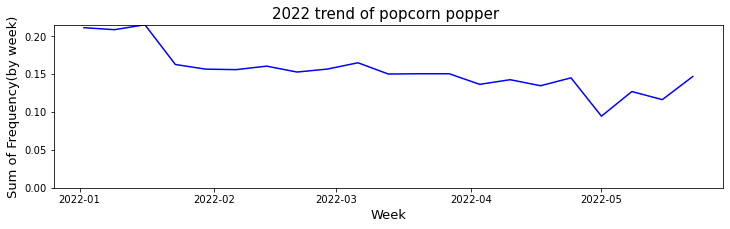

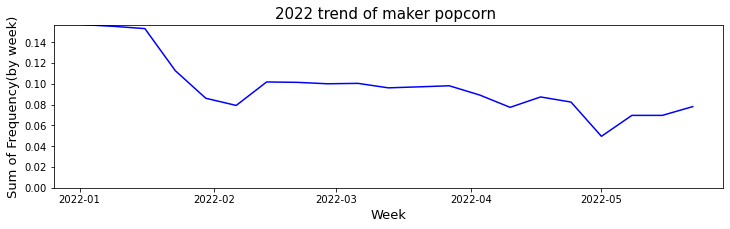

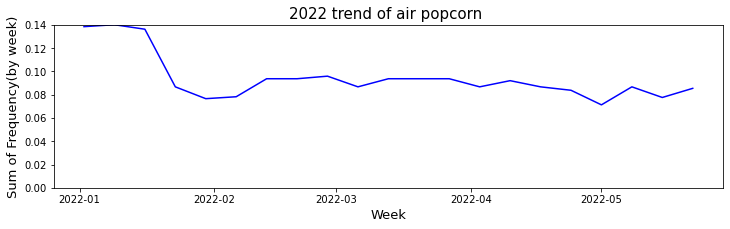

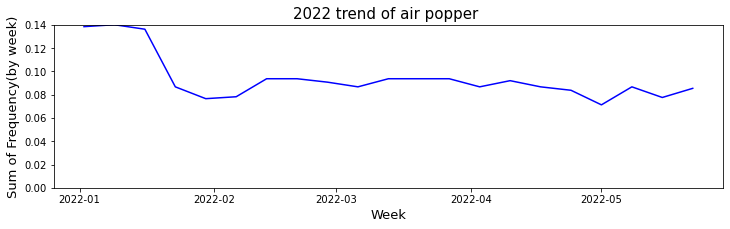

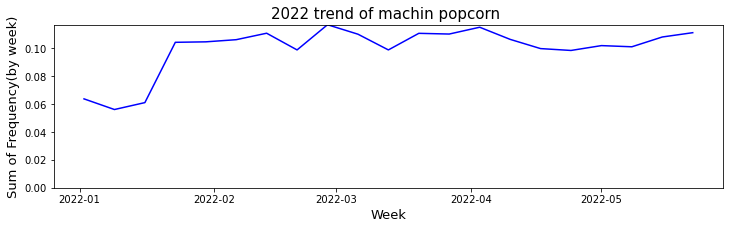

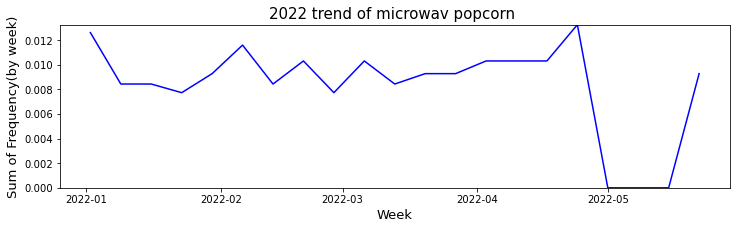

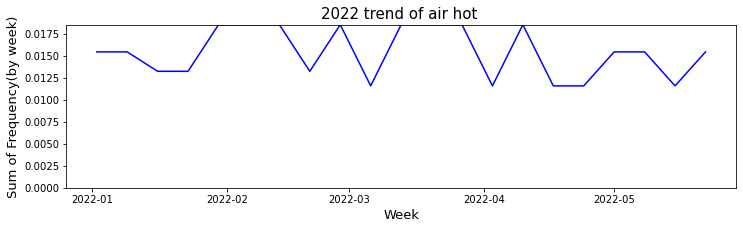

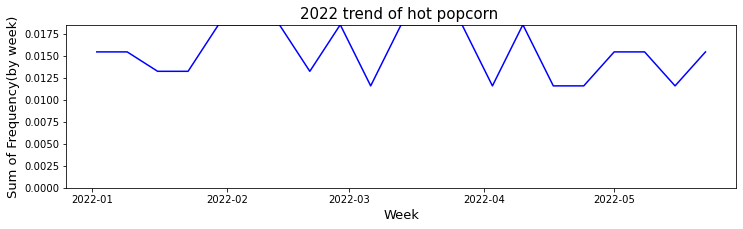

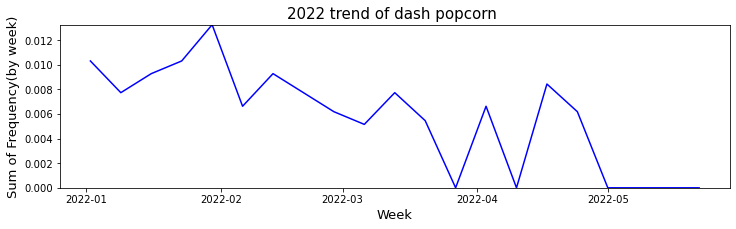

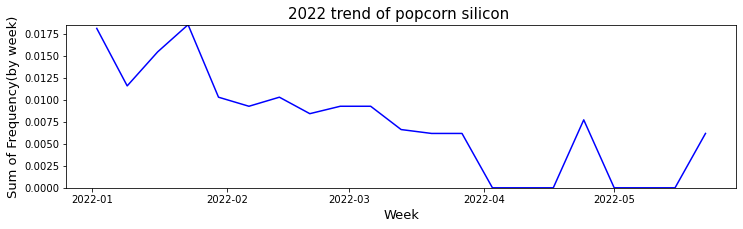

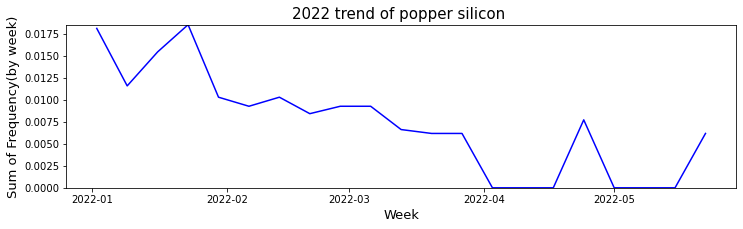

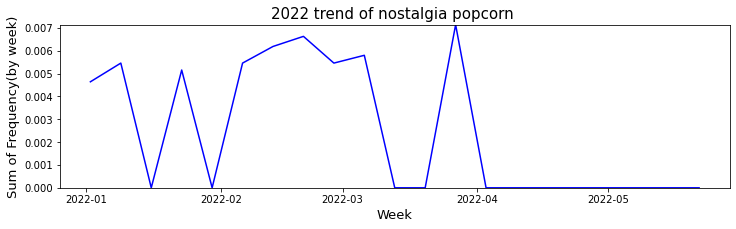

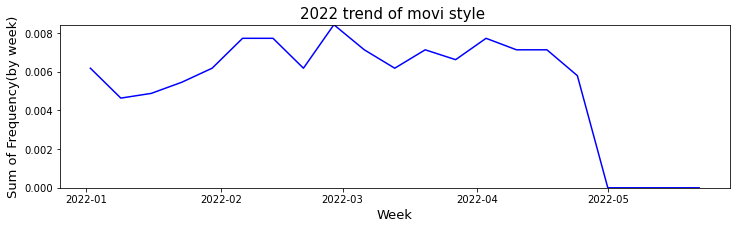

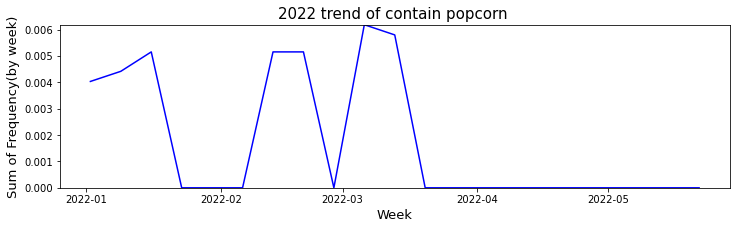

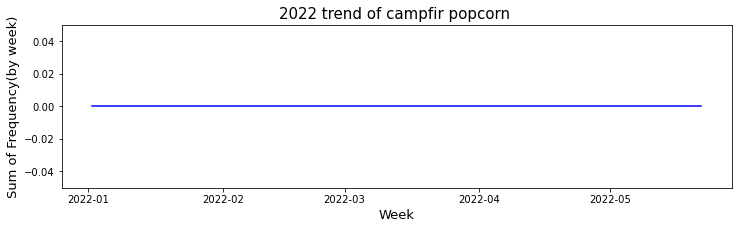

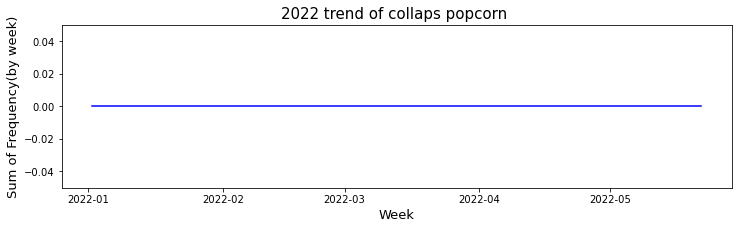

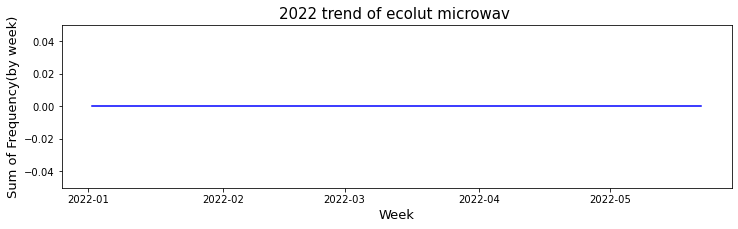

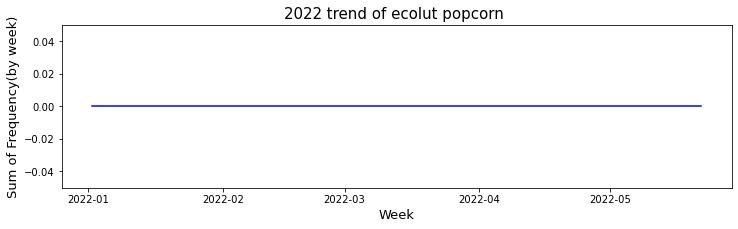

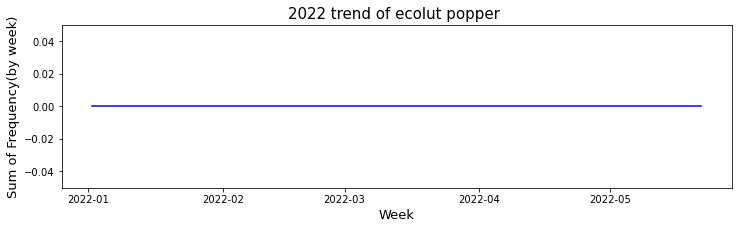

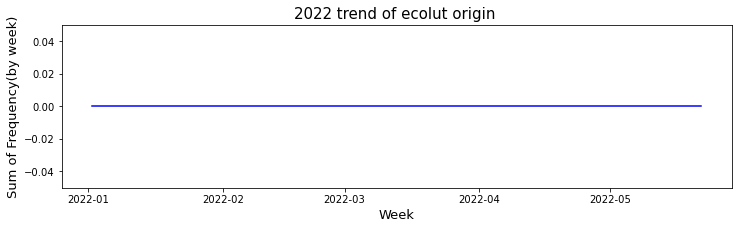

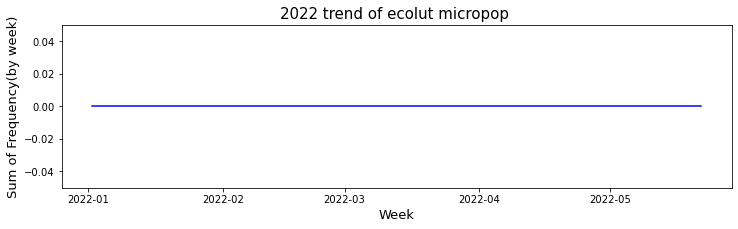

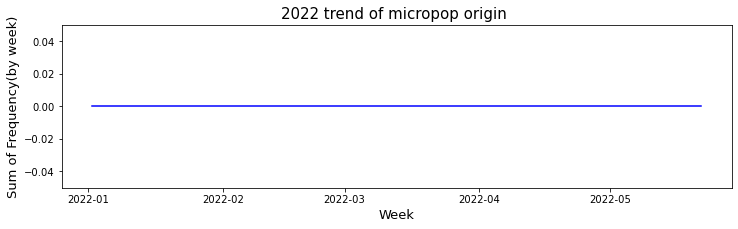

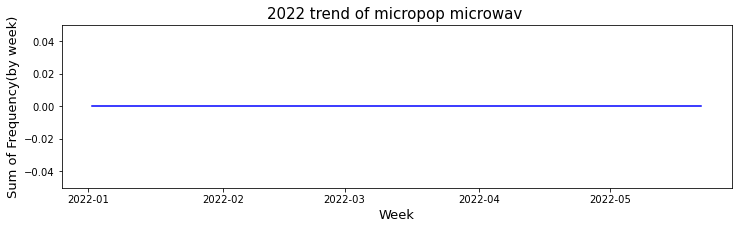

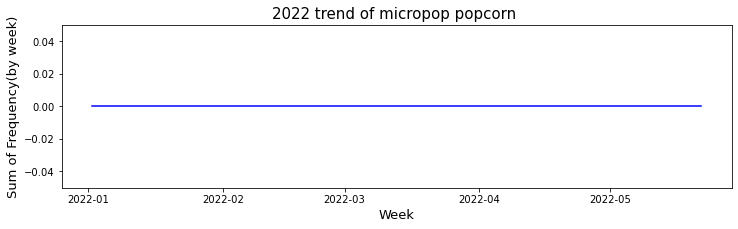

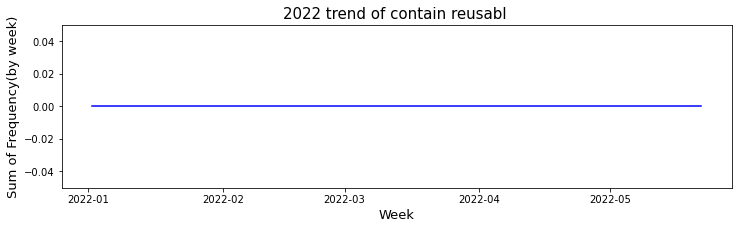

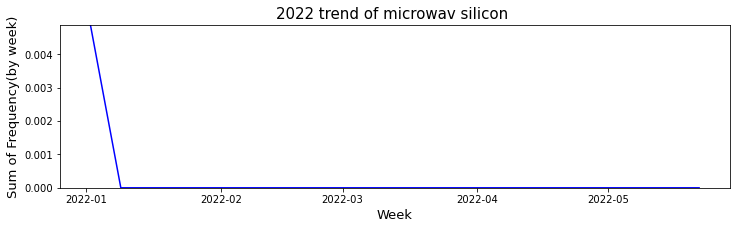

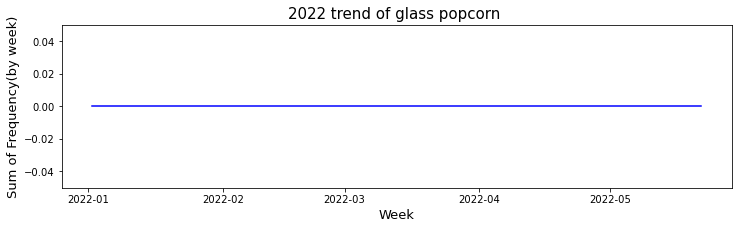

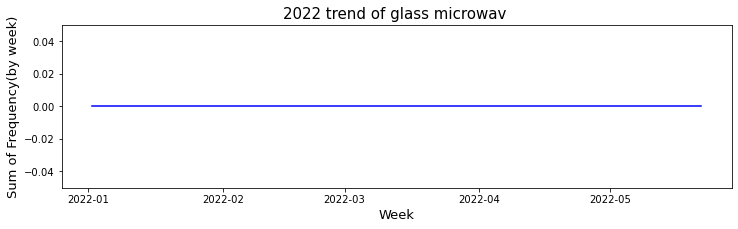

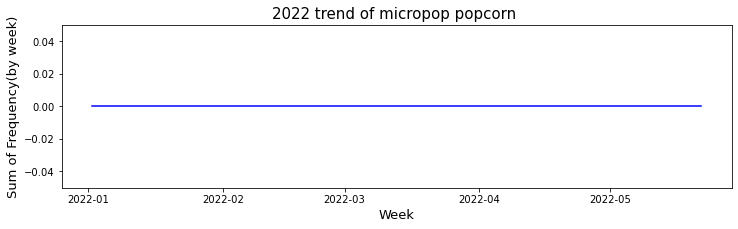

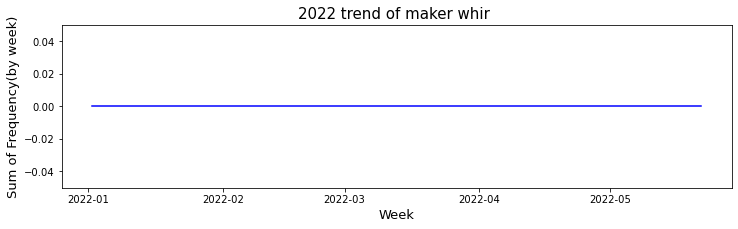

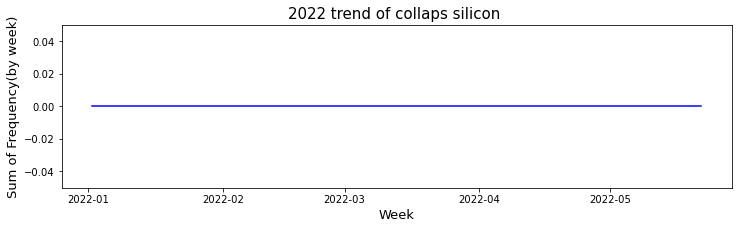

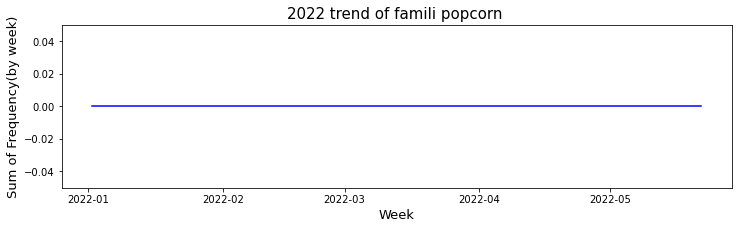

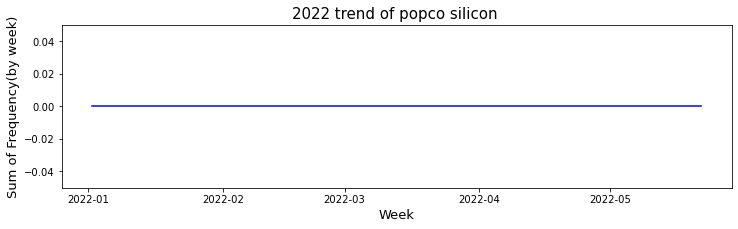

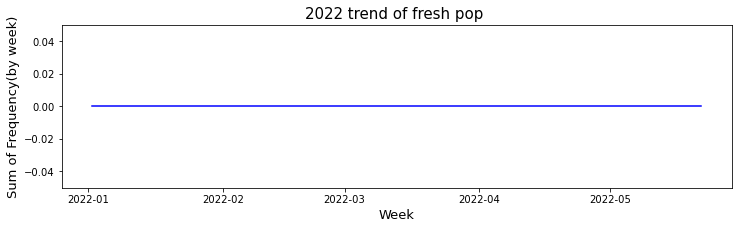

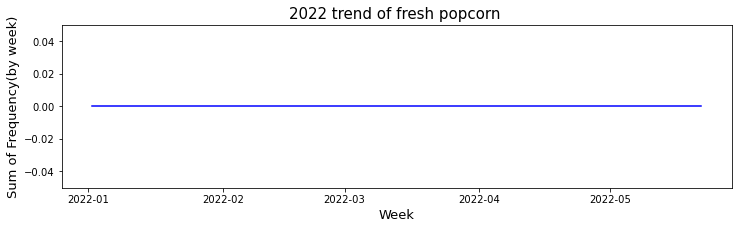

In [10]:
# Plot all Bigrams individually
for i in range(len(df_2)):
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot( df_2[i]['Date'], df_2[i]['Frequency'],'b')
    ax.set_title("2022 trend of %s "%max(df_2[i]["Stemmed_Bigram"]), fontsize=15)
    ax.set_ylabel('Sum of Frequency(by week)', fontsize=13)
    ax.set_xlabel('Week', fontsize=13)
    ax.set_ylim([0,max(df_2[i]["Frequency"])])

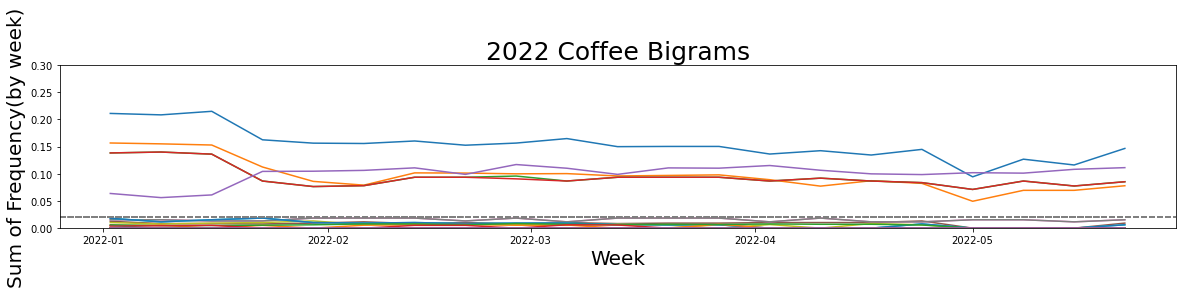

In [42]:
# Plot all Bigrams on the same scale
for i in range(len(df_2)):
    plt.figure(num = 10,figsize=(20,3))
    plt.plot( df_2[i]['Date'], df_2[i]['Frequency'],label = r"%s "%max(df_2[i]["Stemmed_Bigram"]))
    plt.title("2022 Coffee Bigrams", fontsize=25)
    plt.xlabel('Week', fontsize=20)
    plt.ylabel('Sum of Frequency(by week)', fontsize=20)
    plt.axhline(y = 0.02, color = 'grey', linestyle = '--', label='thresholds') # set the threshold as 0.02
    plt.ylim([0,0.3])

### 4.2 Detect Patterns
### 4.2.1 Pattern1: Set threshold: Sum of frequency > = 0.04

In [11]:
df_2_pattern1 = [pattern1(df_2[i]["Frequency"].tolist(),0.02) for i in range(len(df_2))]
df_2_pattern1

['√',
 '√',
 '√',
 '√',
 '√',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

### 4.2.2 Pattern2: Notable Trend

In [12]:
# Calculate the Frequency_diff Dataframe
for i in range(len(df_2)):
    df_2[i]["Freq_Mean"] = df_2[i]["Frequency"].mean()
    df_2[i]["Freq_Lag"] = df_2[i]['Frequency'].shift(1)
    df_2[i]["Freq_Diff"] = pd.DataFrame(df_2[i]["Frequency"]-df_2[i]["Freq_Lag"])
    df_2[i]["Freq_Diff_Std"] = pp.scale(df_2[i]["Freq_Diff"]) #standardize
    df_2[i] = df_2[i].iloc[1:]  #delete first row(no difference value)

/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/3536840453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[i]["Freq_Mean"] = df_2[i]["Frequency"].mean()
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/3536840453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[i]["Freq_Lag"] = df_2[i]['Frequency'].shift(1)
/var/folders/43/byrt76p10c17j17t9lwqb4_r0000gn/T/ipykernel_73856/3536840453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [13]:
# divide all bigrams into 3 categories:
def mark(a): 
    if a > 1:
        return '+'
    elif a <= -1:
        return '-'
    else:
        return 'o'
    
df_mark1 = [(df_2[i].apply(lambda x: mark(x['Freq_Diff_Std']),axis=1))for i in range(len(df_2))]
df_mark1

for i in range(len(df_2)):
    df_2[i]["Label"] = df_mark1[i]  

In [14]:
df_2_pattern2 = [pattern2(df_2[i]['Label'].tolist()) for i in range(len(df_2))]
df_2_pattern2

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 4.2.3 Pattern3: Declining Trend

In [15]:
lst2 = []

for i in range(len(df_2)):
    lst_ = []
    
    x = np.array([i for i in range(len(df_2[i]))]).reshape(-1,1)
    y = df_2[i]["Frequency"].values.reshape(-1,1)
    y.flatten()
    lst_.append(max(df_2[i]["Stemmed_Bigram"]))
    
    model = LinearRegression()
    model.fit(x,y)
    
    Coefficient = model.coef_
    Coefficient = round(float(Coefficient),5)  #should tuning the digits
    lst_.append(Coefficient)
    
    Intercept = model.intercept_
    Intercept = round(float(Intercept),4)
    lst_.append(Intercept)
    
    R_Square = model.score(x,y)
    R_Square = round(float(R_Square),4)
    lst_.append(R_Square)
    
    corr,p = spearmanr(x,y)
    lst_.append(corr)
    lst_.append(p)
     
    lst2.append(lst_)

df_2_1 = pd.DataFrame(lst2, columns = ["Bigram","Coefficient",'Intercept',"R_Square","Correlation","P_Value"]).round(4)
df_2_1

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.p

,Bigram,Coefficient,Intercept,R_Square,Correlation,P_Value
0,popcorn popper,-0.0036,0.1852,0.6310,-0.8883,0.0000
1,maker popcorn,-0.0032,0.1250,0.5873,-0.7965,0.0000
2,air popcorn,-0.0016,0.1072,0.3073,-0.4901,0.0282
3,air popper,-0.0016,0.1068,0.3008,-0.4718,0.0357
4,machin popcorn,0.0012,0.0900,0.2154,0.2475,0.2928
5,microwav popcorn,-0.0002,0.0104,0.1430,-0.0329,0.8905
6,air hot,-0.0001,0.0165,0.0518,-0.2552,0.2775
7,hot popcorn,-0.0001,0.0165,0.0518,-0.2552,0.2775
8,dash popcorn,-0.0005,0.0106,0.5975,-0.7640,0.0001
9,popcorn silicon,-0.0008,0.0139,0.6736,-0.8809,0.0000


In [16]:
df_2_pattern3 = df_2_1.apply(lambda x: pattern3(x['Coefficient'],x['Intercept'],x['P_Value'],x['R_Square']),axis=1)
df_2_pattern3

0     √
1     √
2     √
3     √
4      
5      
6      
7      
8     √
9     √
10    √
11    √
12     
13    √
14     
15     
16     
17     
18     
19     
20     
21     
22     
23     
24     
25     
26     
27     
28     
29     
30     
31     
32     
33     
34     
dtype: object

### 4.2.4 Pattern4: Peak Trend

In [17]:
df_2_pattern4 = [pattern4(df_2[i]["Frequency"],df_2[i]['Freq_Mean']) for i in range(len(df_2))]
df_2_pattern4

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

### 4.2.5 Trend DataFrame

In [18]:
Pattern_22 = pd.DataFrame({"Bigram":df_2_1["Bigram"],"Pattern1": df_2_pattern1,"Pattern2": df_2_pattern2,"Pattern3":df_2_pattern3,"Pattern4":df_2_pattern4})
Pattern_22

,Bigram,Pattern1,Pattern2,Pattern3,Pattern4
0,popcorn popper,√,,√,
1,maker popcorn,√,,√,
2,air popcorn,√,,√,
3,air popper,√,,√,
4,machin popcorn,√,,,
5,microwav popcorn,,,,
6,air hot,,,,
7,hot popcorn,,,,
8,dash popcorn,,,√,
9,popcorn silicon,,,√,
